## Intro

This is an example notebook of my workflow in studying sales data and forecasting it into the future with several different methods. The dataset is alcohol sales, showing monthly alcohol sales during 26 years. The goal is to train two models with the first 23 years of data and try to predict the sales of the next 3 years.

There are several good forecasting models for different scenarios, but here we use:
- LSTM
- SARIMA

**Purpose:** showcase forecasting skills and knowledge of forecasting models.

**Inputs:**  
- alcohol_sales.csv

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose

import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_absolute_error

from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima  

plt.rcParams["figure.figsize"] = (13,4)

### Data loading and exploration
Let's load and plot the data

In [2]:
df = pd.read_csv("data/03 - Sales Forecasting/alcohol_sales.csv")
df.columns = ["date","sales"]
df["date"] = pd.to_datetime(df["date"])
df = df.set_index("date")
df

,sales
date,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221
...,...
2018-09-01,12396
2018-10-01,13914
2018-11-01,14174


In [3]:
# Just to check for any missing values, let's transform the data into a table with 
# month as the column and year as index
pd.pivot_table(df, index=df.index.year, columns=df.index.month, values="sales")

date,1,2,3,4,5,6,7,8,9,10,11,12
date,,,,,,,,,,,,
1992,3459.0,3458.0,4002.0,4564.0,4221.0,4529.0,4466.0,4137.0,4126.0,4259.0,4240.0,4936.0
1993,3031.0,3261.0,4160.0,4377.0,4307.0,4696.0,4458.0,4457.0,4364.0,4236.0,4500.0,4974.0
1994,3075.0,3377.0,4443.0,4261.0,4460.0,4985.0,4324.0,4719.0,4374.0,4248.0,4784.0,4971.0
1995,3370.0,3484.0,4269.0,3994.0,4715.0,4974.0,4223.0,5000.0,4235.0,4554.0,4851.0,4826.0
1996,3699.0,3983.0,4262.0,4619.0,5219.0,4836.0,4941.0,5062.0,4365.0,5012.0,4850.0,5097.0
1997,3758.0,3825.0,4454.0,4635.0,5210.0,5057.0,5231.0,5034.0,4970.0,5342.0,4831.0,5965.0
1998,3796.0,4019.0,4898.0,5090.0,5237.0,5447.0,5435.0,5107.0,5515.0,5583.0,5346.0,6286.0
1999,4032.0,4435.0,5479.0,5483.0,5587.0,6176.0,5621.0,5889.0,5828.0,5849.0,6180.0,6771.0
2000,4243.0,4952.0,6008.0,5353.0,6435.0,6673.0,5636.0,6630.0,5887.0,6322.0,6520.0,6678.0


No missing values in the middle of the data. 2019 only has January's sales.

<Axes: title={'center': 'Sales per time'}, xlabel='date'>

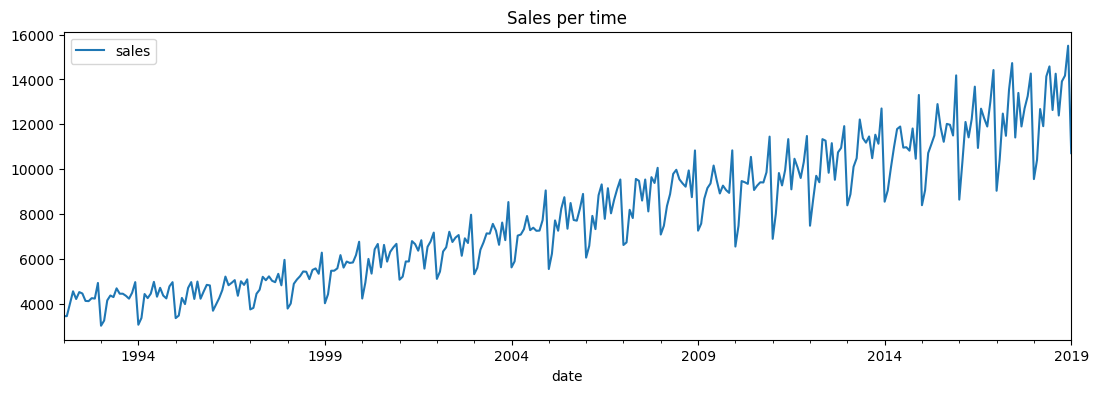

In [4]:
df.plot(title="Sales per time")

The data is montly alcohol sales, from 1992 to 2019. We can see a clear increasing trend. There also seems to be quite regular spikes and dips that might indicate some months are more or less popular than others.

In order to study this further, we can decompose the data. Statsmodels-library has a convenient function seasonal_decompose(), that separates the trend, seasonality and residuals from the data.

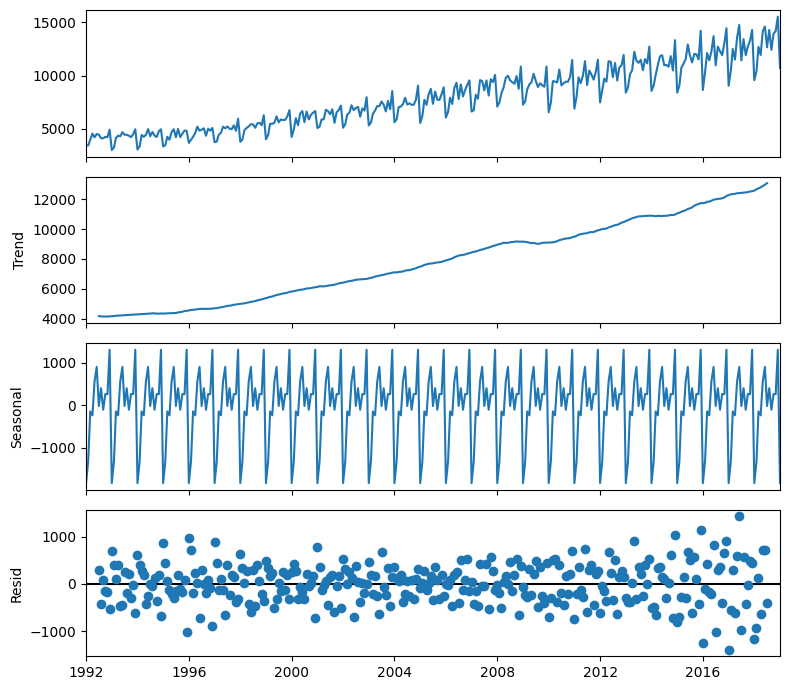

In [5]:
plt.rcParams["figure.figsize"] = (8,7)
decomposed = seasonal_decompose(df)
decomposed.plot()
plt.show()
plt.rcParams["figure.figsize"] = (13,4)

The decomposition shows the original data, the trendline, the seasonal component and residuals. We can see a trend and clear seasionality. The residuals are +- 1000, so quite close to the decomposed seasonality.

In order to confirm if the seasionality, i.e. during some months the sales are higher or lower across every year, we can calculate and plot the autocorrelation. The autocorrelation function shows for each month how similar that month's values are to the other months. Since we are dealing with 12 months in a year, there autocorrelation value should be high for 12 months, meaning no matter what month you look at, the same month in next or previous year sold proportionally the same amount of alcohol.

In order to mitigate the trend, let's use the sales data with the trend removed:

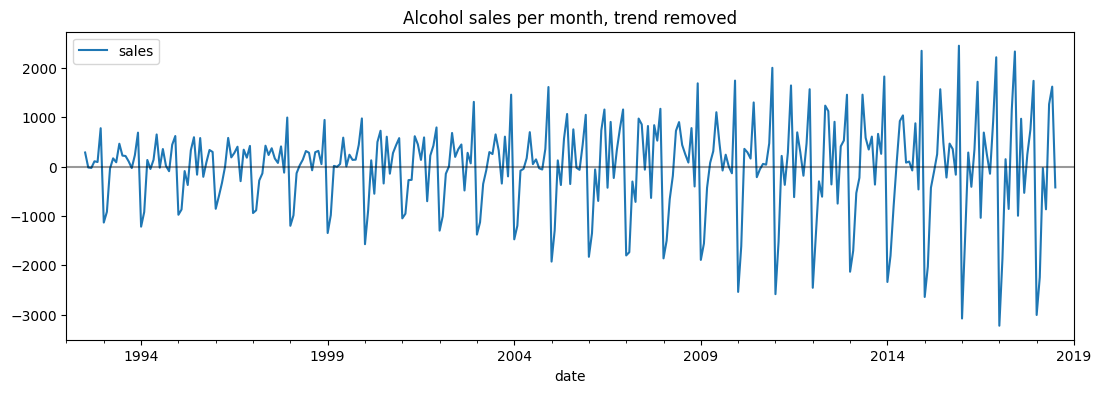

In [6]:
df.subtract(decomposed.trend,axis="rows").plot()
plt.title("Alcohol sales per month, trend removed")
plt.axhline(0,c="k",alpha=0.4)

The variation in the sales seems to increase as time goes by.

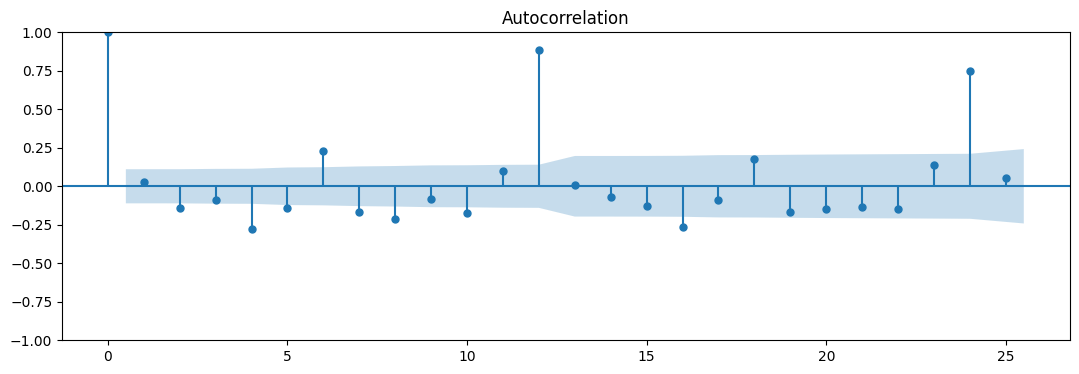

In [7]:
plot_acf(df.subtract(decomposed.trend,axis="rows").dropna())
plt.show()

The autocorerlation plot shows the autocorrelation values as blue dots at the end of the lines, as well as a confidence interval as a light blue area. If the autocorrelation values lie within the blue area, there is no correlation. 

We can clearly see, apart from the 0'th month with obvious correlation of 1, that there is a huge correlation on 12 and 24 months. That confirms the theory that the sales depend heavily on the month, and each year's sales are relatively about the same.

Text(0.5, 1.0, "Montly sale's deviation from year's average")

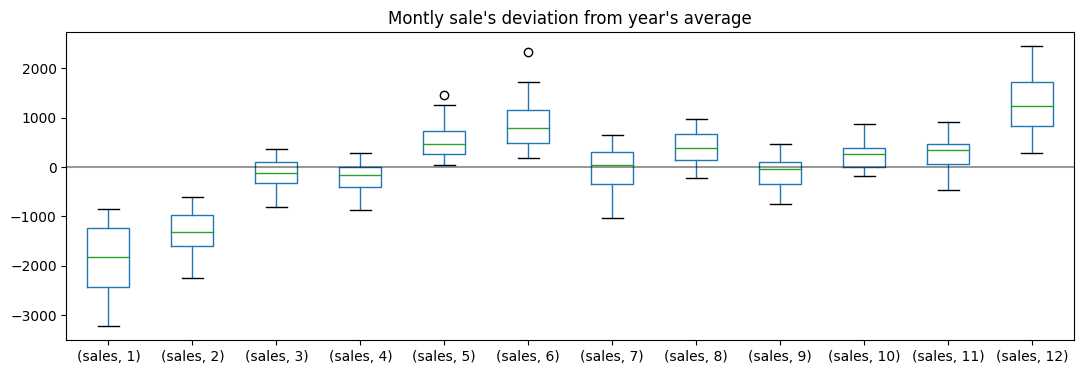

In [8]:
pd.pivot_table(df.subtract(decomposed.trend,axis="rows"), index=df.index.year, columns=df.index.month).boxplot()
plt.grid(alpha=0)
plt.axhline(0,c="k",alpha=0.4)
plt.title("Montly sale's deviation from year's average")

From the boxplot we can see that the sales are the lowest on January and highest on June and December, possibly due to summer and Christmas. Because of June and December are 6 months apart, as well as some other months and their +6 month counterpart match, we can actually also see a slight autocorrelation at 6 months in the autocorrelation graph. 

### Predictions with LSTM
Long short-term memory (LSTM) is a popular recurrent neural network (RNN) algorithm, that is cabable of learning sequential information and storing it, and thus being able to calculate what might happen next.

LSTM is available as a module in Tensorflow, which we will use here.

In [9]:
# Set seed for reproduceability
tf.random.set_seed(1)

In [10]:
# Use first 23 year's sales as training data, try to predict the next 3 years
test_years = 3 
train_data = df[:len(df)-(test_years*12)]
test_data = df[len(df)-(test_years*12):]

# LSTM requires data that is between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))

# Scale the data
scaler.fit(train_data)
train_data_scaled = scaler.transform(train_data)
test_data_scaled = scaler.transform(test_data)
print(f"Total number of measurements: {len(df)}")
print(f"Train months: {len(train_data)}")
print(f"Test months: {len(test_data)}")

Total number of measurements: 325
Train months: 289
Test months: 36


In [11]:
# Build a genenrator for LSTM, input is one season i.e. 12 months. We have only 1 feature.
n_input = 12
n_features= 1
generator = TimeseriesGenerator(train_data_scaled, train_data_scaled, length=n_input, batch_size=1)

Like with other machine Tensorflow learning models, we could also build a deep multi-layer network of LSTM model. But let's just keep it simple with one LSTM layer with 200 units, which goes to a dense 12-unit layer and finally to a single dense value. We're using Adam as the optimizer and track MSE loss.

In [12]:
lstm_model = Sequential()
lstm_model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
lstm_model.add(Dense(12))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 200)               161600    
                                                                 
 dense (Dense)               (None, 12)                2412      
                                                                 
 dense_1 (Dense)             (None, 1)                 13        
                                                                 
Total params: 164,025
Trainable params: 164,025
Non-trainable params: 0
_________________________________________________________________


In [13]:
# Train for 20 epochs
lstm_model.fit(generator, epochs=20)

Epoch 1/20
277/277 [==============================] - 18s 55ms/step - loss: 0.0149
Epoch 2/20
277/277 [==============================] - 14s 50ms/step - loss: 0.0101
Epoch 3/20
277/277 [==============================] - 14s 50ms/step - loss: 0.0081
Epoch 4/20
277/277 [==============================] - 15s 53ms/step - loss: 0.0085
Epoch 5/20
277/277 [==============================] - 14s 49ms/step - loss: 0.0061
Epoch 6/20
277/277 [==============================] - 14s 52ms/step - loss: 0.0053
Epoch 7/20
277/277 [==============================] - 14s 52ms/step - loss: 0.0036
Epoch 8/20
277/277 [==============================] - 14s 50ms/step - loss: 0.0030
Epoch 9/20
277/277 [==============================] - 15s 53ms/step - loss: 0.0034
Epoch 10/20
277/277 [==============================] - 14s 51ms/step - loss: 0.0027
Epoch 11/20
277/277 [==============================] - 16s 59ms/step - loss: 0.0021
Epoch 12/20
277/277 [==============================] - 14s 50ms/step - loss: 0.0018
E

<Axes: >

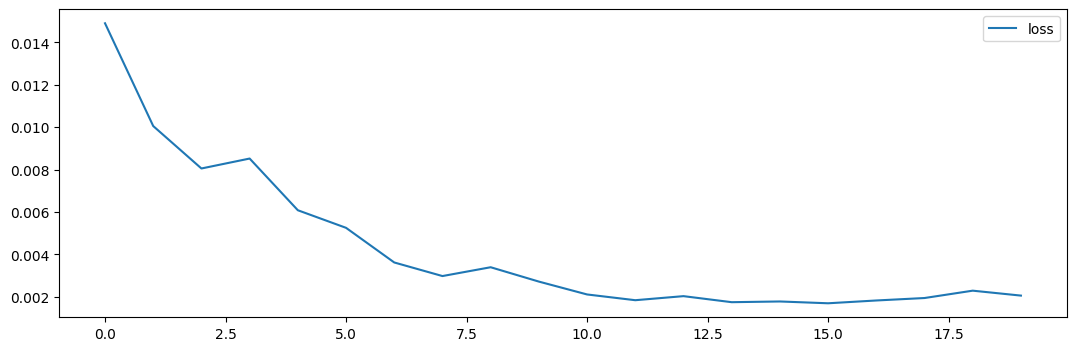

In [14]:
pd.DataFrame(lstm_model.history.history).plot()

We build predictions with LSTM one-by-one using a sliding window. The first iteration uses the last 12 months of training data to make the next month's prediction, which is added to a list of predictions. The prediction is then added to the end of the sliding window while removing the first value. This way we always have 12 values to use for the prediction of next month. This is done for the whole length of the test data. 

In [15]:
lstm_predictions_raw = []

iteration = train_data_scaled[-n_input:].reshape((1, n_input, n_features))

for i in range(len(test_data)):   
    lstm_pred = lstm_model.predict(iteration)[0]
    lstm_predictions_raw.append(lstm_pred) 
    iteration = np.append(iteration[:,1:,:],[[lstm_pred]],axis=1)

1/1 [==============================] - 0s 25ms/step


In [16]:
# The predictions are scaled, use inverse_transform to scale them back to original scale
lstm_predictions = scaler.inverse_transform(lstm_predictions_raw)
test_data = test_data.rename(columns={"sales":"True values"})
test_data['LSTM'] = lstm_predictions

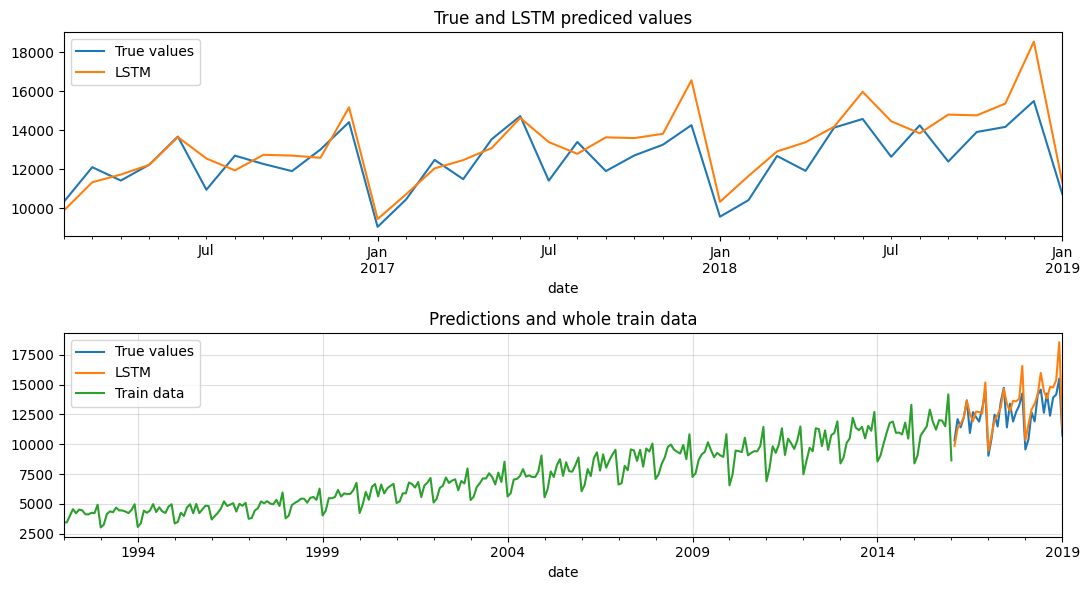

In [17]:
fig,axes = plt.subplots(2,1,figsize=(11,6))
test_data[["True values","LSTM"]].plot(ax=axes[0],title="True and LSTM prediced values")

test_data[["True values","LSTM"]].plot(ax=axes[1], title="Predictions and whole train data")
train_data.rename(columns={"sales":"Train data"}).plot(ax=axes[1])
plt.grid(alpha=0.4)
plt.tight_layout()

In [18]:
error_rmse = round(rmse(test_data["True values"], test_data["LSTM"]))
error_mae = round(mean_absolute_error(test_data["True values"], test_data["LSTM"]))
print("RMSE: ", error_rmse)
print("MAE: ", error_mae)
print("Mean of true values: ", round(test_data["True values"].mean()))

RMSE:  1159
MAE:  905
Mean of true values:  12518


LSTM works really well. Most of the year the sales match, especially the dips in January, but the LSTM seems to over-estimate the December sales slightly. The root mean squared error (RMSE) of 1159 and mean absolute error (MAE) of 905 are small compared to the mean value of 12518 of the test set.

### (S)ARIMA

Another model we can try is ARIMA. AutoRegressive Integrated Moving Average is a statistical model that is used for time series analysis for its cababilities in predicting values using the past data. It also can handle trends, but not seasonality. Since our data has clear seasonality, we use a seasonal version of ARIMA with exogenous factors, called SARIMAX. 

SARIMAX requires 7 input parameters, called p,d,q,P,D,Q and S. Good values for the parameters could be tried by hand, but there is also a module called auto_arima that does that task for us. The last parameter, S, is the seasonality, which in our case is 12 months.

In [19]:
auto_arima(df, seasonal=True, m=12, max_p=6, max_d=3, max_P=5, max_Q=4).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  325
Model:             SARIMAX(5, 1, 1)x(4, 1, [], 12)   Log Likelihood               -2208.079
Date:                             Fri, 06 Oct 2023   AIC                           4438.157
Time:                                     21:59:19   BIC                           4479.330
Sample:                                 01-01-1992   HQIC                          4454.613
                                      - 01-01-2019                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7091      0.200     -3.542      0.000      -1.101      -0.317
ar.L2         -0.5027      0.175     -2.880      0.004      -0.845      -0.161
ar.L3         -0.2093      0.141     -1.488      0.137      -0.485       0.066
ar.L4         -0.3283      0.080     -4.102      0.000      -0.485      -0.171
ar.L5         -0.2155      0.064     -3.376      0.001      -0.341      -0.090
ma.L1         -0.1403      0.212     -0.661      0.509      -0.556       0.276
ar.S.L12      -0.3655      0.048     -7.649      0.000      -0.459      -0.272
ar.S.L24      -0.4592      0.046    -10.057      0.000      -0.549      -0.370
ar.S.L36      -0.4487      0.060     -7.482      0.000      -0.566      -0.331
ar.S.L48      -0.4790      0.058     -8.287      0.000      -0.592      -0.366
sigma2      7.691e+04   6436.202     11.949      0.000    6.43e+04    8.95e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                 2.71
Prob(Q):                              0.83   Prob(JB):                         0.26
Heteroskedasticity (H):               4.21   Skew:                             0.00
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The best model seems to be SARIMAX(5, 1, 1)x(4, 1, [], 12), where each value corresponds to the parameter. Let's set the sixth value to 3 and fit the model.

In [20]:
%%time
arima_model = SARIMAX(train_data, order = (5,1,1), seasonal_order = (4,1,3,12))
arima_result = arima_model.fit()
arima_result.summary()

C:\Users\Anton\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Anton\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Anton\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\Anton\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


CPU times: total: 8min 39s
Wall time: 1min 36s


<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                          
==================================================================================================
Dep. Variable:                                      sales   No. Observations:                  289
Model:             SARIMAX(5, 1, 1)x(4, 1, [1, 2, 3], 12)   Log Likelihood               -1935.201
Date:                                    Fri, 06 Oct 2023   AIC                           3898.401
Time:                                            22:00:56   BIC                           3949.087
Sample:                                        01-01-1992   HQIC                          3918.740
                                             - 01-01-2016                                         
Covariance Type:                                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0576      0.244      0.237      0.813      -0.420       0.535
ar.L2          0.1163      0.228      0.510      0.610      -0.331       0.563
ar.L3          0.3235      0.189      1.713      0.087      -0.047       0.694
ar.L4         -0.0530      0.120     -0.441      0.659      -0.288       0.183
ar.L5          0.0790      0.138      0.571      0.568      -0.192       0.350
ma.L1         -0.8911      0.240     -3.705      0.000      -1.362      -0.420
ar.S.L12       0.2122      0.445      0.477      0.634      -0.660       1.085
ar.S.L24      -0.7268      0.331     -2.196      0.028      -1.375      -0.078
ar.S.L36      -0.3324      0.354     -0.939      0.348      -1.026       0.362
ar.S.L48      -0.2998      0.156     -1.919      0.055      -0.606       0.006
ma.S.L12      -0.5374      0.467     -1.152      0.249      -1.452       0.377
ma.S.L24       0.6082      0.471      1.292      0.196      -0.315       1.531
ma.S.L36       0.0595      0.415      0.144      0.886      -0.753       0.872
sigma2      9.361e+04   1.24e+04      7.534      0.000    6.93e+04    1.18e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.26   Jarque-Bera (JB):                 4.27
Prob(Q):                              0.61   Prob(JB):                         0.12
Heteroskedasticity (H):               3.96   Skew:                             0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [21]:
# Predicting with SARIMAX is easier than with LSTM
arima_predictions = arima_result.predict(start = len(train_data), end = len(df)-1).rename("ARIMA Predictions")
test_data['ARIMA'] = arima_predictions

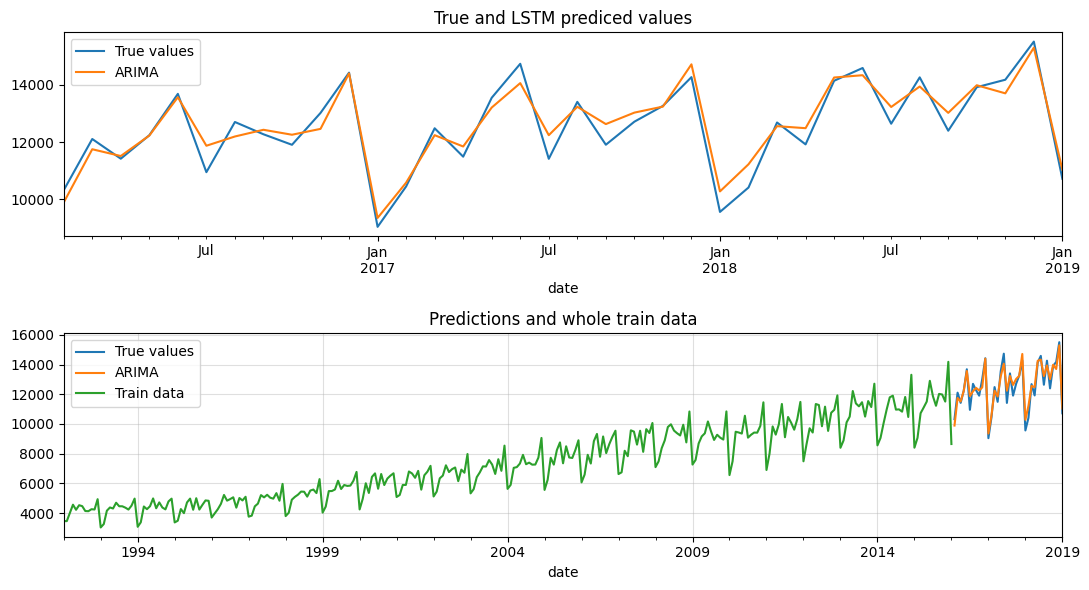

In [22]:
fig,axes = plt.subplots(2,1,figsize=(11,6))
test_data[["True values","ARIMA"]].plot(ax=axes[0],title="True and LSTM prediced values")

test_data[["True values","ARIMA"]].plot(ax=axes[1], title="Predictions and whole train data")
train_data.rename(columns={"sales":"Train data"}).plot(ax=axes[1])
plt.grid(alpha=0.4)
plt.tight_layout()

In [23]:
error_rmse = round(rmse(test_data["True values"], test_data["ARIMA"]))
error_mae = round(mean_absolute_error(test_data["True values"], test_data["ARIMA"]))
print("RMSE: ", error_rmse)
print("MAE: ", error_mae)
print("Mean of true values: ", round(test_data["True values"].mean()))

RMSE:  443
MAE:  368
Mean of true values:  12518


ARIMA seems to outperform LSTM and results in very accurate predictions. RMSE and MAE are only 443 and 368 respectively.

Below are the both two predictions with the true values.

<Axes: title={'center': 'True and prediced values'}, xlabel='date'>

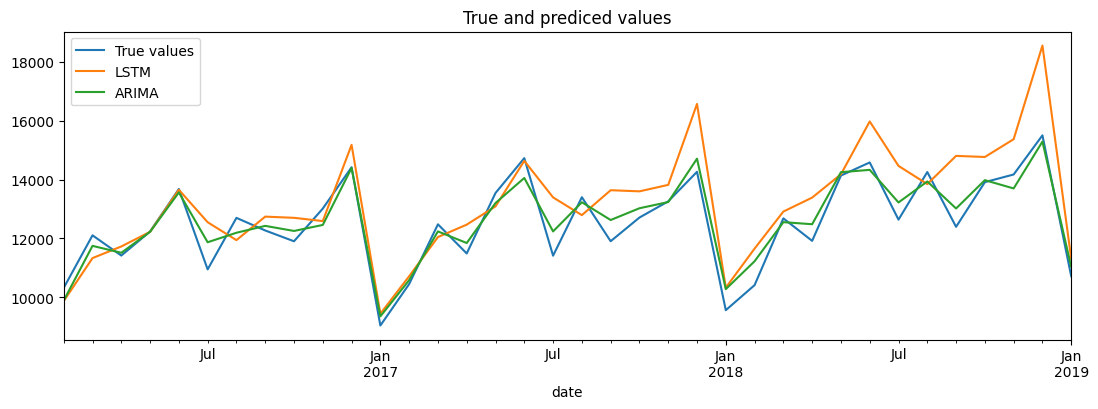

In [24]:
test_data.plot(title="True and prediced values")